# Backward feature selection

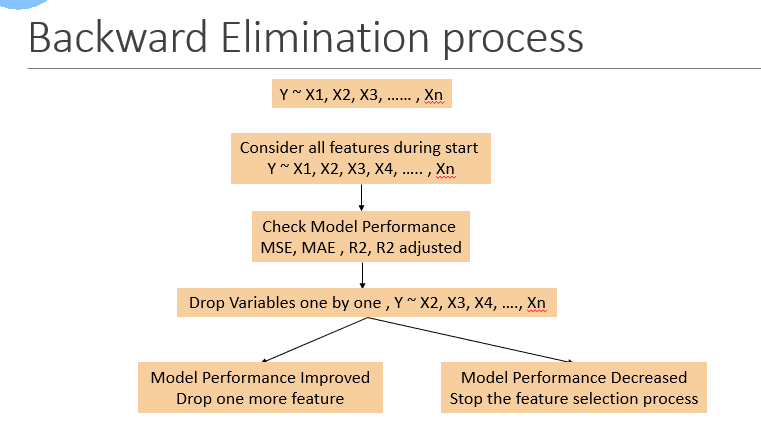

In [3]:
a = 12
print(a)

12


In [4]:
from warnings import filterwarnings
filterwarnings("ignore")

# Estimate weight of car based on other features
# Select the relevant features to estimate accurate weight

# Step 1 - Data ingestion

In [5]:
import pandas as pd
df = pd.read_csv("Cars93.csv", na_values=["", "NA"], keep_default_na=False)
df.head()

,id,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin,Make
0,1,Acura,Integra,Small,12.9,15.9,18.8,25,31,None,...,5,177,102,68,37,26.5,11.0,2705,non-USA,Acura Integra
1,2,Acura,Legend,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,...,5,195,115,71,38,30.0,15.0,3560,non-USA,Acura Legend
2,3,Audi,90,Compact,25.9,29.1,32.3,20,26,Driver only,...,5,180,102,67,37,28.0,14.0,3375,non-USA,Audi 90
3,4,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,...,6,193,106,70,37,31.0,17.0,3405,non-USA,Audi 100
4,5,BMW,535i,Midsize,23.7,30.0,36.2,22,30,Driver only,...,4,186,109,69,39,27.0,13.0,3640,non-USA,BMW 535i


# Step 2 - Perform basic data quality check

In [6]:
df.shape

(94, 28)

In [7]:
df.duplicated().sum()

np.int64(1)

In [8]:
df = df.drop_duplicates(keep="first").reset_index(drop=True)
df.shape

(93, 28)

In [9]:
df.duplicated().sum()

np.int64(0)

In [10]:
m = df.isna().sum()
m[m > 0]

AirBags            4
Rear.seat.room     2
Luggage.room      11
dtype: int64

# Drop the high cardinality columns

In [11]:
c = df.select_dtypes(include="object").nunique()
c

Manufacturer       32
Model              93
Type                6
AirBags             3
DriveTrain          3
Cylinders           6
Man.trans.avail     2
Origin              2
Make               93
dtype: int64

In [12]:
card = c / len(df)
card

Manufacturer       0.344086
Model              1.000000
Type               0.064516
AirBags            0.032258
DriveTrain         0.032258
Cylinders          0.064516
Man.trans.avail    0.021505
Origin             0.021505
Make               1.000000
dtype: float64

In [13]:
high_card_cols = card[card >= 0.9].index
high_card_cols

Index(['Model', 'Make'], dtype='object')

In [14]:
df = df.drop(columns = high_card_cols)
df.head()

,id,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Weight,Origin
0,1,Acura,Small,12.9,15.9,18.8,25,31,None,Front,...,13.2,5,177,102,68,37,26.5,11.0,2705,non-USA
1,2,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,...,18.0,5,195,115,71,38,30.0,15.0,3560,non-USA
2,3,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,...,16.9,5,180,102,67,37,28.0,14.0,3375,non-USA
3,4,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,21.1,6,193,106,70,37,31.0,17.0,3405,non-USA
4,5,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,...,21.1,4,186,109,69,39,27.0,13.0,3640,non-USA


# Step 3 - Seperate X and Y(Weight)
id should be dropped because it is just a serial number

In [15]:
X = df.drop(columns=["id", "Weight"])
Y = df["Weight"]

In [16]:
X.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
0,Acura,Small,12.9,15.9,18.8,25,31,None,Front,4,...,Yes,13.2,5,177,102,68,37,26.5,11.0,non-USA
1,Acura,Midsize,29.2,33.9,38.7,18,25,Driver & Passenger,Front,6,...,Yes,18.0,5,195,115,71,38,30.0,15.0,non-USA
2,Audi,Compact,25.9,29.1,32.3,20,26,Driver only,Front,6,...,Yes,16.9,5,180,102,67,37,28.0,14.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
4,BMW,Midsize,23.7,30.0,36.2,22,30,Driver only,Rear,4,...,Yes,21.1,4,186,109,69,39,27.0,13.0,non-USA


In [17]:
Y.head()

0    2705
1    3560
2    3375
3    3405
4    3640
Name: Weight, dtype: int64

# Step 4 - Apply train test split

In [18]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(
    X, Y, test_size=0.2, random_state=10
)

In [19]:
xtrain.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
42,Honda,Compact,13.8,17.5,21.2,24,31,Driver & Passenger,Front,4,...,Yes,17.0,4,185,107,67,41,28.0,14.0,non-USA
53,Mazda,Small,10.9,11.6,12.3,28,36,None,Front,4,...,Yes,14.5,5,172,98,66,36,26.5,13.0,non-USA
21,Chrysler,Large,29.5,29.5,29.5,20,26,NaN,Front,6,...,No,16.0,6,203,110,69,44,36.0,17.0,USA
6,Buick,Large,19.9,20.8,21.7,19,28,Driver only,Front,6,...,No,18.0,6,200,111,74,42,30.5,17.0,USA
26,Dodge,Midsize,14.8,15.6,16.4,21,27,Driver only,Front,4,...,No,16.0,6,192,105,69,42,30.5,16.0,USA


In [20]:
ytrain.head()

42    3040
53    2440
21    3570
6     3470
26    3080
Name: Weight, dtype: int64

In [21]:
xtest.head()

,Manufacturer,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,Cylinders,...,Man.trans.avail,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin
34,Ford,Sporty,12.8,14.0,15.2,24,30,Driver only,Front,4,...,Yes,15.5,4,179,103,70,38,23.0,18.0,USA
90,Volkswagen,Sporty,22.9,23.3,23.7,18,25,None,Front,6,...,Yes,18.5,4,159,97,66,36,26.0,15.0,non-USA
3,Audi,Midsize,30.8,37.7,44.6,19,26,NaN,Front,6,...,Yes,21.1,6,193,106,70,37,31.0,17.0,non-USA
35,Ford,Van,14.5,19.9,25.3,15,20,Driver only,4WD,6,...,Yes,21.0,7,176,119,72,45,30.0,NaN,USA
19,Chrylser,Large,18.4,18.4,18.4,20,28,Driver & Passenger,Front,6,...,No,18.0,6,203,113,74,40,31.0,15.0,USA


In [22]:
ytest.head()

34    2710
90    2810
3     3405
35    3735
19    3515
Name: Weight, dtype: int64

In [23]:
xtrain.shape

(74, 24)

In [24]:
xtest.shape

(19, 24)

# Step 5 - Apply preprocessing on X

1. Categorical - Replace missing value by most frequent -> OneHotEncoder / Ordinal
2. Numerical - Replace missing values by mean, median -> StandardScaler

In [25]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

In [26]:
num_pipe = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler()
)

In [27]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
    StandardScaler()
)

In [28]:
cat_cols = xtrain.select_dtypes(include="object").columns.tolist()
num_cols = xtrain.select_dtypes(include="number").columns.tolist()

pre = ColumnTransformer(
    [
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ]
).set_output(transform="pandas")

pre.fit(xtrain)

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [29]:
xtrain_pre = pre.transform(xtrain)
xtrain_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
42,-0.373824,-0.208643,-0.071922,0.318308,0.363084,-0.499737,-0.070927,0.583333,0.553885,0.094849,...,0.554316,0.028926,0.031956,-0.330948,-1.373237,-1.720536,-0.180439,-0.763650,0.780189,1.114641
53,-0.699007,-0.802086,-0.851002,1.066078,1.322665,-0.871400,-0.759572,0.416667,-0.190474,-0.664766,...,-0.987766,-0.458372,-0.314235,0.266373,0.474391,1.173093,-0.180439,-0.763650,0.780189,1.114641
21,1.386650,0.998360,0.654635,-0.429463,-0.596496,0.522338,0.059357,-0.750000,-1.020721,-0.208997,...,1.479565,2.627852,1.070530,-0.928269,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
6,0.310182,0.123283,-0.028154,-0.616405,-0.212664,0.986917,0.487434,-0.750000,-1.431073,0.398695,...,0.862732,0.841091,1.070530,-1.286661,-0.757361,-0.273722,-0.180439,0.975122,-1.281740,-0.897150
26,-0.261692,-0.399752,-0.492100,-0.242520,-0.404580,-0.220989,-0.815408,-0.750000,0.277136,-0.208997,...,0.862732,0.841091,0.724339,-0.808804,-0.141485,-0.273722,-0.180439,-0.763650,-1.281740,-0.897150


In [30]:
xtest_pre = pre.transform(xtest)
xtest_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
34,-0.485956,-0.560685,-0.597145,0.318308,0.171168,-0.685568,-0.536227,0.416667,0.038559,-0.360920,...,-0.370933,-1.595402,1.416722,-0.569876,1.090267,-0.273722,-0.180439,-0.763650,0.780189,-0.897150
90,0.646578,0.374742,0.146920,-0.803348,-0.788412,0.057759,0.636330,0.916667,0.124447,0.550618,...,-0.987766,-0.620805,0.378148,1.699942,1.090267,1.173093,-0.180439,0.975122,0.780189,1.114641
3,1.532421,1.823145,1.976445,-0.616405,-0.596496,0.057759,0.524658,0.416667,0.410739,1.340618,...,-0.679350,1.003523,1.070530,-1.525589,-0.141485,-0.273722,-0.180439,0.975122,0.780189,1.114641
35,-0.295332,0.032758,0.286980,-1.364176,-1.747992,0.243590,0.022133,-0.750000,-0.457680,1.310233,...,1.787981,0.678658,0.000000,-0.569876,1.706143,-0.273722,-2.087934,0.975122,0.780189,-0.897150
19,0.141983,-0.118118,-0.317026,-0.429463,-0.212664,0.522338,0.171029,0.083333,-0.629455,0.398695,...,0.245900,1.003523,0.378148,-1.764517,-0.757361,-1.720536,-0.180439,0.975122,-1.281740,-0.897150


# Step 6 - Model building

# Check the model score without feature selection

In [31]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression()
model1.fit(xtrain_pre, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [32]:
model1.intercept_

np.float64(3087.567567567568)

In [33]:
model1.coef_

array([ 2.06407983e+03, -4.58780433e+03,  2.59674218e+03,  5.58440201e+01,
       -1.43419251e+02, -1.22648162e+02,  2.73991905e+02, -1.04804071e+02,
       -5.07770479e+01,  1.03696736e+02,  1.89135395e+01,  5.57991770e+01,
        2.40545292e+02, -4.43359543e+01,  2.88055727e+01, -3.01025617e+01,
        5.07497978e+01,  3.99166132e+00,  5.39157189e+01, -1.59160557e+01,
       -1.08530876e+01,  1.43701830e+01,  2.07213680e+01,  4.99623699e+01])

In [34]:
coef = pd.Series(model1.coef_, index=xtrain_pre.columns)
coef

num__Min.Price             2064.079831
num__Price                -4587.804333
num__Max.Price             2596.742182
num__MPG.city                55.844020
num__MPG.highway           -143.419251
num__EngineSize            -122.648162
num__Horsepower             273.991905
num__RPM                   -104.804071
num__Rev.per.mile           -50.777048
num__Fuel.tank.capacity     103.696736
num__Passengers              18.913540
num__Length                  55.799177
num__Wheelbase              240.545292
num__Width                  -44.335954
num__Turn.circle             28.805573
num__Rear.seat.room         -30.102562
num__Luggage.room            50.749798
cat__Manufacturer             3.991661
cat__Type                    53.915719
cat__AirBags                -15.916056
cat__DriveTrain             -10.853088
cat__Cylinders               14.370183
cat__Man.trans.avail         20.721368
cat__Origin                  49.962370
dtype: float64

In [35]:
train_r2 = model1.score(xtrain_pre, ytrain)
print(train_r2)

0.9725393359755347


In [36]:
test_r2 = model1.score(xtest_pre, ytest)
print(test_r2)

0.8227111354006142


In [37]:
gen_err = abs(train_r2 - test_r2)
print(gen_err)

0.1498282005749204


# Feature selection

In [38]:
from sklearn.feature_selection import SequentialFeatureSelector

lr = LinearRegression()
sel = SequentialFeatureSelector(
    lr, n_features_to_select="auto", direction="backward", scoring="r2"
) # Change the direction to backward
sel.fit(xtrain_pre, ytrain)

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,'r2'
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [39]:
sel_cols = sel.get_feature_names_out()
print(sel_cols)

['num__Min.Price' 'num__Price' 'num__MPG.highway' 'num__EngineSize'
 'num__Horsepower' 'num__RPM' 'num__Rev.per.mile'
 'num__Fuel.tank.capacity' 'num__Length' 'num__Wheelbase' 'cat__Type'
 'cat__Origin']


In [40]:
len(sel_cols)

12

In [41]:
xtrain_pre_sel = sel.transform(xtrain_pre)
xtrain_pre_sel[0:5]

array([[-0.37382411, -0.20864295,  0.36308441, -0.49973664, -0.07092689,
         0.58333333,  0.55388468,  0.09484922,  0.07553707,  0.4504151 ,
        -1.3732369 ,  1.11464086],
       [-0.69900714, -0.80208604,  1.32266464, -0.87140007, -0.75957166,
         0.41666667, -0.19047443, -0.66476576, -0.83279622, -0.91311426,
         0.47439093,  1.11464086],
       [ 1.38664954,  0.99835994, -0.59649582,  0.5223378 ,  0.05935726,
        -0.75      , -1.02072113, -0.20899677,  1.33322932,  0.90492489,
        -0.75736096, -0.89714996],
       [ 0.31018158,  0.12328284, -0.21266373,  0.98691709,  0.48743374,
        -0.75      , -1.43107295,  0.39869522,  1.12361394,  1.05642815,
        -0.75736096, -0.89714996],
       [-0.26169203, -0.39975175, -0.40457977, -0.22098907, -0.81540773,
        -0.75      ,  0.27713578, -0.20899677,  0.56463961,  0.14740858,
        -0.14148501, -0.89714996]])

In [42]:
xtest_pre_sel = sel.transform(xtest_pre)
xtest_pre_sel[0:5]

array([[-0.48595619, -0.56068546,  0.17116836, -0.68556836, -0.53622741,
         0.41666667,  0.03855914, -0.36091977, -0.34369368, -0.15559794,
         1.09026688, -0.89714996],
       [ 0.64657782,  0.37474178, -0.78841186,  0.05775851,  0.6363299 ,
         0.91666667,  0.12444673,  0.55061821, -1.7411295 , -1.06461752,
         1.09026688,  1.11464086],
       [ 1.53242124,  1.82314524, -0.59649582,  0.05775851,  0.52465778,
         0.41666667,  0.4107387 ,  1.3406178 ,  0.6345114 ,  0.29891184,
        -0.14148501,  1.11464086],
       [-0.29533165,  0.03275762, -1.74799209,  0.24359022,  0.02213321,
        -0.75      , -0.45768026,  1.3102332 , -0.55330905,  2.26845425,
         1.70614282, -0.89714996],
       [ 0.14198346, -0.11811774, -0.21266373,  0.5223378 ,  0.17102938,
         0.08333333, -0.62945544,  0.39869522,  1.33322932,  1.35943468,
        -0.75736096, -0.89714996]])

# Fit the model on selected columns

In [43]:
model_backward = LinearRegression()
model_backward.fit(xtrain_pre_sel, ytrain)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [44]:
model_backward.intercept_

np.float64(3087.5675675675675)

In [45]:
model_backward.coef_

array([   0.27766459,  -34.57863973, -106.8682189 , -128.24546364,
        276.10311781, -114.19316827,  -44.1526052 ,   93.81862005,
         62.36783343,  241.7380316 ,   47.08689989,   45.92142228])

In [46]:
coefs = pd.Series(model_backward.coef_, index=sel_cols)
coefs

num__Min.Price               0.277665
num__Price                 -34.578640
num__MPG.highway          -106.868219
num__EngineSize           -128.245464
num__Horsepower            276.103118
num__RPM                  -114.193168
num__Rev.per.mile          -44.152605
num__Fuel.tank.capacity     93.818620
num__Length                 62.367833
num__Wheelbase             241.738032
cat__Type                   47.086900
cat__Origin                 45.921422
dtype: float64

<Axes: >

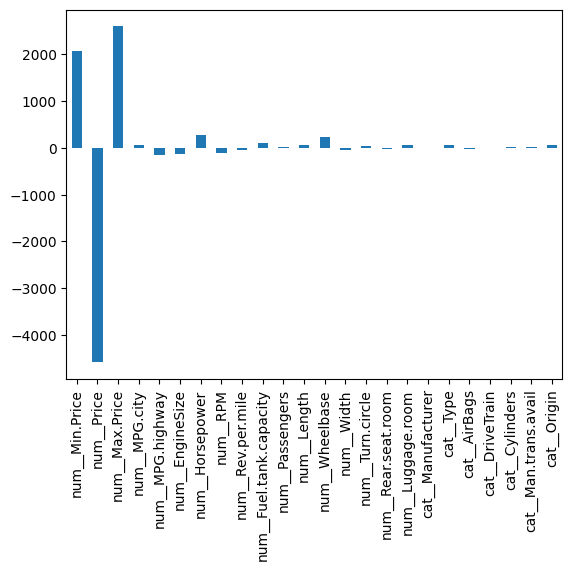

In [47]:
coef.plot(kind="bar")

In [48]:
# Show r2 score on train and test
train_r2 = model_backward.score(xtrain_pre_sel, ytrain)
test_r2 = model_backward.score(xtest_pre_sel, ytest)
gen_err = abs(train_r2 - test_r2)
print(f"Train R2 : {train_r2:.2%}")
print(f"Test R2 : {test_r2:.2%}")
print(f"Generalization Error : {gen_err:.2%}")

Train R2 : 96.92%
Test R2 : 84.06%
Generalization Error : 12.86%


# Evaluate the model in detail

In [49]:
from sklearn.metrics import (
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

def evaluate_model(model, x, y):
    ypred = model.predict(x)
    rmse = root_mean_squared_error(y, ypred)
    mae = mean_absolute_error(y, ypred)
    mape = mean_absolute_percentage_error(y, ypred)
    r2 = r2_score(y, ypred)
    print(f"RMSE : {rmse:.2f}")
    print(f"MAE : {mae:.2f}")
    print(f"MAPE : {mape:.2%}")
    print(f"R2 : {r2:.2%}")

In [50]:
print("Train Results : ")
evaluate_model(model_backward, xtrain_pre_sel, ytrain)

Train Results : 
RMSE : 107.04
MAE : 88.49
MAPE : 2.98%
R2 : 96.92%


In [51]:
print("Test Results : ")
evaluate_model(model_backward, xtest_pre_sel, ytest)

Test Results : 
RMSE : 192.42
MAE : 144.06
MAPE : 4.86%
R2 : 84.06%


# Above model can be used for out of sample prediction

# Model Inference - Out of sample prediction 

In [52]:
xnew = pd.read_csv("sample.csv", na_values=["", "NA"], keep_default_na=False)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Fuel.tank.capacity,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,15.0,6,190,106,65,37,31.0,17.0,non-USA,Audi 100
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,15.2,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,16.5,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,20.0,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,12.4,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox


In [53]:
pre

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [54]:
sel

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,'r2'
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [55]:
xnew_pre = pre.transform(xnew)
xnew_pre.head()

,num__Min.Price,num__Price,num__Max.Price,num__MPG.city,num__MPG.highway,num__EngineSize,num__Horsepower,num__RPM,num__Rev.per.mile,num__Fuel.tank.capacity,...,num__Turn.circle,num__Rear.seat.room,num__Luggage.room,cat__Manufacturer,cat__Type,cat__AirBags,cat__DriveTrain,cat__Cylinders,cat__Man.trans.avail,cat__Origin
0,1.532421,1.823145,1.976445,-0.616405,-0.596496,0.057759,0.524658,0.416667,0.410739,-0.512843,...,-0.679350,1.003523,1.070530,-1.525589,-0.141485,-0.273722,-0.180439,0.975122,0.780189,1.114641
1,-0.867205,-0.852378,-0.807234,0.131365,0.363084,-0.685568,-0.629288,-0.083333,0.658858,-0.452074,...,-0.062517,-0.945671,-0.314235,0.983157,-1.373237,1.173093,-0.180439,-0.763650,0.780189,-0.897150
2,-0.418677,-0.369577,-0.317026,-0.242520,-0.020748,-0.499737,-0.629288,-0.083333,0.525255,-0.057074,...,0.245900,0.191359,0.724339,-1.047733,-0.141485,1.173093,-0.180439,-0.763650,-1.281740,-0.897150
3,1.723046,1.300111,0.917246,-0.990291,-0.788412,-1.335979,2.069456,2.083333,0.009930,1.006387,...,-0.679350,0.000000,0.000000,0.266373,1.090267,-0.273722,1.727057,-2.502421,0.780189,1.114641
4,-0.945698,-1.053545,-1.096106,0.505250,0.746917,-0.871400,-1.169036,0.416667,0.439368,-1.302842,...,-1.604599,-0.620805,-1.352810,1.699942,0.474391,1.173093,-0.180439,-0.763650,0.780189,1.114641


In [56]:
xnew_pre_sel = sel.transform(xnew_pre)
xnew_pre_sel

array([[ 1.53242124,  1.82314524, -0.59649582,  0.05775851,  0.52465778,
         0.41666667,  0.4107387 , -0.51284277,  0.42489603,  0.29891184,
        -0.14148501,  1.11464086],
       [-0.86720526, -0.85237783,  0.36308441, -0.68556836, -0.62928752,
        -0.08333333,  0.6588584 , -0.45207357, -0.20395009, -0.45860447,
        -1.3732369 , -0.89714996],
       [-0.41867694, -0.36957667, -0.02074768, -0.49973664, -0.62928752,
        -0.08333333,  0.52525548, -0.05707377,  0.98387036,  0.60191837,
        -0.14148501, -0.89714996],
       [ 1.72304578,  1.30011066, -0.78841186, -1.33597936,  2.06945551,
         2.08333333,  0.00992995,  1.00638721, -1.04241159, -1.21612078,
         1.09026688,  1.11464086],
       [-0.94569771, -1.05354498,  0.7469165 , -0.87140007, -1.16903612,
         0.41666667,  0.43936789, -1.30284235, -1.46164234, -1.67063057,
         0.47439093,  1.11464086]])

In [57]:
preds = model_backward.predict(xnew_pre_sel)
preds

array([3255.60214796, 2700.74236997, 3132.76680149, 3469.66709788,
       2222.19057096])

In [58]:
xnew["Weight"] = preds.round(2)
xnew

,Manufacturer,Model,Type,Min.Price,Price,Max.Price,MPG.city,MPG.highway,AirBags,DriveTrain,...,Passengers,Length,Wheelbase,Width,Turn.circle,Rear.seat.room,Luggage.room,Origin,Make,Weight
0,Audi,100,Midsize,30.8,37.7,44.6,19,26,NaN,Front,...,6,190,106,65,37,31.0,17.0,non-USA,Audi 100,3255.60
1,Pontiac,Sunbird,Compact,9.4,11.1,12.8,23,31,None,Front,...,5,181,101,66,39,25.0,13.0,USA,Pontiac Sunbird,2700.74
2,Chevrolet,Lumina,Midsize,13.4,15.9,18.4,21,29,None,Front,...,6,198,108,71,40,28.5,16.0,USA,Chevrolet Lumina,3132.77
3,Mazda,RX-7,Sporty,32.5,32.5,32.5,17,25,Driver only,Rear,...,2,169,96,69,37,NaN,NaN,non-USA,Mazda RX-7,3469.67
4,Volkswagen,Fox,Small,8.7,9.1,9.5,25,33,None,Front,...,4,163,93,63,34,26.0,10.0,non-USA,Volkswagen Fox,2222.19


In [59]:
xnew.to_csv("backward_res.csv", index=False)

# Save the preprocessor, sel and model object

In [60]:
pre

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [61]:
sel

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,'r2'
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None


In [62]:
model_backward

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [63]:
import joblib
joblib.dump(pre, "backward_pre.joblib")

['backward_pre.joblib']

In [64]:
joblib.dump(sel, "backward_sel.joblib")

['backward_sel.joblib']

In [65]:
joblib.dump(model_backward, "backward_model.joblib")

['backward_model.joblib']

# Load the model objects

In [66]:
p = joblib.load("backward_pre.joblib")
p

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


In [67]:
m = joblib.load("backward_model.joblib")
m

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [68]:
s = joblib.load("backward_sel.joblib")
s

,estimator,LinearRegression()
,n_features_to_select,'auto'
,tol,None
,direction,'backward'
,scoring,'r2'
,cv,5
,n_jobs,None
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
